In [65]:
import numpy as np
import matplotlib.pyplot as plt
import ase
from ase import Atoms
from ase.visualize import view

Plot Lennard-Jones Potential

Text(0, 0.5, 'U / ε')

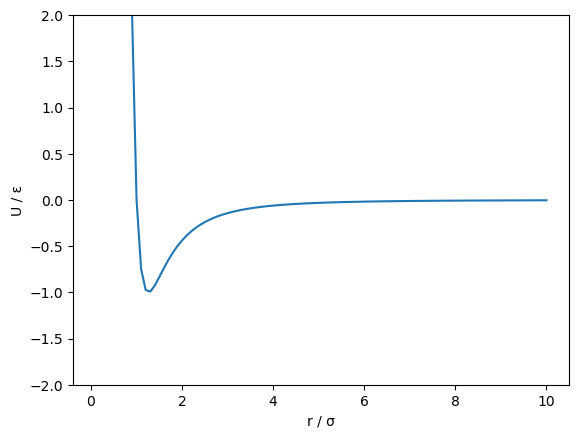

In [66]:
x = np.linspace(0.1, 10, 100)
r2i = 1 / x
r6i = r2i**3
 
ecut = 0
y = 4 * r6i * (r6i - 1) - ecut
plt.plot(x,y)
plt.ylim(-2, 2)
plt.xlabel('r / σ')
plt.ylabel('U / ε')


MD Code

In [67]:
class MD:
    def __init__(self, n_particles, box_length, temperature, dt=0.005, read_positions=False):
        self.n_particles = n_particles
        self.box_length = box_length
        self.temperature = temperature
        self.dt = dt
        self.read_positions = read_positions
        self.positions, self.old_positions, self.velocities, self.U_kin = self.initialise_system(read_positions)
        # self.positions, self.old_positions, self.velocities, self.U_kin = self.initialise_system_random()

        self.forces, self.potential_energy, self.pressure = self.calculate_forces()



    def initialise_system(self, read_positions):

        if read_positions:
            positions = np.load('positions.npy')[-1] # load final frame of previous simulation as starting positions
        
        else:
            positions = np.zeros((self.n_particles, 3))

            n_per_dim = int(np.ceil(self.n_particles ** (1/3))) # n_particles should be a perfect cube

            # Calculate the spacing between particles
            spacing = self.box_length / n_per_dim

            counter = 0

            # Place particles on a lattice
            for i in range(n_per_dim):
                for j in range(n_per_dim):
                    for k in range(n_per_dim):
                        if counter < self.n_particles:
                            positions[counter] = np.array([i, j, k]) * spacing
                            counter += 1
        
        old_positions = np.zeros((self.n_particles, 3))
        velocities = np.zeros((self.n_particles, 3))

        # Initialize velocities with Maxwell-Boltzmann distribution
        velocities = np.random.normal(0, np.sqrt(self.temperature), (self.n_particles, 3))

        # Remove center of mass motion
        momentum = np.sum(velocities, axis=0) / self.n_particles
        velocities -= momentum

        # Rescale velocities to match desired temperature
        kinetic_energy = 0.5 * np.sum(velocities**2)
        scale_factor = np.sqrt((3 * self.n_particles * self.temperature) / (2 * kinetic_energy))
        velocities *= scale_factor

        # Get old positions for velocity verlet
        old_positions = positions - velocities * self.dt

        return positions, old_positions, velocities, kinetic_energy
    

    def initialise_system_random(self):


        def check_overlap(positions, new_position, cutoff):
            for position in positions:
                if np.linalg.norm(position - new_position) < cutoff:
                    return True

        positions = np.zeros((self.n_particles, 3))
        for i in range(self.n_particles):
            print(i)
            n_trials = 0
            cutoff = 1.122
            trial_position = np.random.rand(3) * self.box_length
            while check_overlap(positions, trial_position, cutoff):
                trial_position = np.random.rand(3) * self.box_length
                n_trials += 1
                if n_trials > 1000:
                    print('Reducing cutoff')
                    cutoff -= 0.05
            positions[i] = trial_position

        positions = np.random.rand(self.n_particles, 3) * self.box_length
        velocities = np.random.normal(0, np.sqrt(self.temperature), (self.n_particles, 3))
        momentum = np.sum(velocities, axis=0) / self.n_particles
        velocities -= momentum
        kinetic_energy = 0.5 * np.sum(velocities**2)
        scale_factor = np.sqrt((3 * self.n_particles * self.temperature) / (2 * kinetic_energy))
        velocities *= scale_factor
        old_positions = positions - velocities * self.dt
        return positions, old_positions, velocities, kinetic_energy


    def calculate_forces(self):
        forces = np.zeros((self.n_particles, 3))
        potential_energy = 0.0
        pressure = 0.0
        
        cutoff = 0.5 * self.box_length 
        cutoff2 = cutoff ** 2
        ecut = 4 * (cutoff**-12 - cutoff**-6)  # Correct cutoff energy shift
        
        for i in range(self.n_particles):
            for j in range(i + 1, self.n_particles):
                xr = self.positions[i] - self.positions[j]
                # Minimum image convention (PBC)
                xr -= self.box_length * np.round(xr / self.box_length)
                r2 = np.dot(xr, xr)
                
                if r2 < cutoff2:  
                    r2i = 1.0 / r2
                    r6i = r2i ** 3
                    force_magnitude = 48 * r2i * r6i * (r6i - 0.5)  # LJ potential force magnitude
                    force = force_magnitude * xr
                    
                    forces[i] += force
                    forces[j] -= force
                
                    potential_energy += 4 * r6i * (r6i - 1) - ecut  # Shifted LJ potential
                    pressure += np.dot(force, xr)
        
        # Pressure normalization
        pressure /= (3.0 * self.box_length ** 3)
        
        return forces, potential_energy, pressure

   
    def euler(self):
        new_positions = self.positions + self.velocities * self.dt + 0.5 * self.forces * self.dt ** 2
        self.positions = new_positions
        new_velocities = self.velocities + 0.5 * self.forces * self.dt
        self.velocities = new_velocities

    def verlet(self):

        new_positions = np.zeros((self.n_particles, 3))
        new_positions = 2.0 * self.positions - self.old_positions + (self.forces * self.dt ** 2)
        self.velocities = (new_positions - self.old_positions) / (2.0 * self.dt)
        self.U_kin = 0.5 * np.sum(self.velocities**2)
        self.old_positions = self.positions
        self.positions = new_positions

    def velocity_verlet(self):
        # Half-step velocity update
        velocities_half = self.velocities + 0.5 * self.forces * self.dt
        
        # Full position update
        self.positions += velocities_half * self.dt
        
        # Recalculate forces based on the new positions
        self.forces, self.potential_energy, self.pressure = self.calculate_forces()
        
        # Full-step velocity update using the new forces
        self.velocities = velocities_half + 0.5 * self.forces * self.dt


    def calculate_temperature(self):
        # Calculate kinetic energy
        kinetic_energy = 0.5 * np.sum(self.velocities**2)
        # Calculate temperature
        temperature = (2 * kinetic_energy) / (3 * self.n_particles)
        return temperature

    def do_MD(self, n_steps, integrator):

        properties = np.zeros((n_steps, 5))
        positions = np.zeros((n_steps, self.n_particles, 3))
        for step in range(n_steps):

            self.forces, self.potential_energy, self.pressure = self.calculate_forces()
            if integrator == 'euler':
                self.euler()
            elif integrator == 'velocity_verlet':
                self.velocity_verlet()
            else:
                print('Must choose an integrator: euler or velocity_verlet')
                
            kinetic_energy = 0.5 * np.sum(self.velocities**2)
            total_energy = kinetic_energy + self.potential_energy
            temperature = self.calculate_temperature()
            properties[step] = np.array([step, kinetic_energy, self.potential_energy, total_energy, temperature])
            positions[step][:] = self.positions
            header = "# step kinetic_energy potential_energy total_energy temperature"

            print(f"Step {step}, Kinetic Energy: {kinetic_energy:.3f}, Potential Energy: {self.potential_energy:.3f}, Total Energy: {total_energy:.3f}, Temperature: {temperature:.2f}")
        np.savetxt('data.txt', properties, header=header, comments='', fmt='%.8f')
        np.save('positions.npy', positions)


        return positions, properties



Step 1: Initialisation

In [68]:
# Set Argon parameters
n_particles = 125
sigma_ar = 3.4E-10  # Lennard-Jones sigma for argon in meters
kb = 1.38064852E-23  # Boltzmann constant in J/K
epsilon_ar = 120 * kb  # Argon epsilon in J
mass_ar = 39.95 * 1.6747E-24  # Argon mass in grams
temperature = 94.4  # Argon temperature in K
density = 1.374 * 1E6  # In g/m^3
dt = 1E-14  # Time step in seconds
box_length = (mass_ar * n_particles / (density)) ** (1/3) #metres

box_length_lj = box_length / sigma_ar # In LJ units
print('box_length*',box_length_lj)

temperature_lj = temperature * kb / epsilon_ar # In LJ units
print('T*',temperature_lj)

dt_lj = dt / (sigma_ar * np.sqrt(mass_ar / epsilon_ar)) # In LJ units
print('dt*',dt_lj)

print('SI',n_particles, box_length, temperature, dt)
n_particles = 125
print('LJ units',n_particles, box_length_lj, temperature_lj, dt_lj)

box_length* 5.370072030161947
T* 0.7866666666666667
dt* 0.0001463613375934729
SI 125 1.8258244902550621e-09 94.4 1e-14
LJ units 125 5.370072030161947 0.7866666666666667 0.0001463613375934729


Step 1: Initialise simulation

In [69]:
md_simulation = MD(n_particles, box_length_lj, temperature_lj, dt_lj, read_positions = False)

In [70]:
system = Atoms(['Ar'] * md_simulation.n_particles, positions = md_simulation.positions * sigma_ar*1E10)
system.set_cell([box_length_lj * sigma_ar*1E10, box_length_lj * sigma_ar*1E10, box_length_lj * sigma_ar*1E10])
view(system, viewer = 'x3d')


Run simulation

In [72]:
n_steps = 100
# Run MD simulation
positions, properties = md_simulation.do_MD(n_steps, integrator='velocity_verlet')


Step 0, Kinetic Energy: 118.652, Potential Energy: -594.270, Total Energy: -475.618, Temperature: 0.63
Step 1, Kinetic Energy: 118.380, Potential Energy: -593.998, Total Energy: -475.618, Temperature: 0.63
Step 2, Kinetic Energy: 118.108, Potential Energy: -593.726, Total Energy: -475.618, Temperature: 0.63
Step 3, Kinetic Energy: 117.834, Potential Energy: -593.452, Total Energy: -475.618, Temperature: 0.63
Step 4, Kinetic Energy: 117.560, Potential Energy: -593.178, Total Energy: -475.618, Temperature: 0.63
Step 5, Kinetic Energy: 117.285, Potential Energy: -592.903, Total Energy: -475.618, Temperature: 0.63
Step 6, Kinetic Energy: 117.010, Potential Energy: -592.628, Total Energy: -475.618, Temperature: 0.62
Step 7, Kinetic Energy: 116.733, Potential Energy: -592.351, Total Energy: -475.618, Temperature: 0.62
Step 8, Kinetic Energy: 116.456, Potential Energy: -592.074, Total Energy: -475.618, Temperature: 0.62
Step 9, Kinetic Energy: 116.179, Potential Energy: -591.797, Total Energy

Monitor properties (e.g. energy conservation, temperature )

In [74]:
fig, ax = plt.subplots()
data = np.loadtxt('data.txt')
tot_energy = data[:,3]

ax.plot(np.arange(n_steps), tot_energy)
ax.ticklabel_format(style='plain')
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.set_xlabel('Step')
ax.set_ylabel('Total Energy')


Run simulation at target temperature

In [ ]:
# Run MD simulation
md_simulation = MD(n_particles, box_length_lj, temperature_lj, dt_lj, read_positions=True)
n_steps = 1000
positions, properties = md_simulation.do_MD(n_steps, integrator='velocity_verlet')


Step 0, Kinetic Energy: 147.471, Potential Energy: -604.177, Total Energy: -456.706, Temperature: 0.79
Step 1, Kinetic Energy: 147.441, Potential Energy: -604.147, Total Energy: -456.706, Temperature: 0.79
Step 2, Kinetic Energy: 147.410, Potential Energy: -604.117, Total Energy: -456.706, Temperature: 0.79
Step 3, Kinetic Energy: 147.379, Potential Energy: -604.085, Total Energy: -456.706, Temperature: 0.79
Step 4, Kinetic Energy: 147.346, Potential Energy: -604.053, Total Energy: -456.706, Temperature: 0.79
Step 5, Kinetic Energy: 147.313, Potential Energy: -604.019, Total Energy: -456.706, Temperature: 0.79
Step 6, Kinetic Energy: 147.279, Potential Energy: -603.985, Total Energy: -456.706, Temperature: 0.79
Step 7, Kinetic Energy: 147.244, Potential Energy: -603.950, Total Energy: -456.706, Temperature: 0.79
Step 8, Kinetic Energy: 147.208, Potential Energy: -603.914, Total Energy: -456.706, Temperature: 0.79
Step 9, Kinetic Energy: 147.171, Potential Energy: -603.877, Total Energy

Get Radial Distribution Function

In [75]:
positions = np.load('positions.npy')

def get_rdf(positions, nbins=100):
    box_length = box_length_lj
    gr = np.zeros((nbins,2))
    dg = box_length / (2 * nbins)

    bin_index = 0
    for k in range(positions.shape[0]):
        for i in range(n_particles):
            for j in range(i+1, n_particles):
                rij = positions[k][i] - positions[k][j]
                rij -= box_length * np.round(rij / box_length)
                r = np.linalg.norm(rij)
                if r < box_length / 2:
                    bin_index = int(r / dg)
                    gr[bin_index][1] += 2
    
    for i in range(nbins): #final normalisation
        r = (i + 0.5) * dg
        v = (4 * np.pi / 3) * (n_particles / box_length**3) * dg**3 * ((i + 1) **3 - i**3)
        gr[i][1] /= (v * n_particles)
        gr[i][0] = r

    return gr

rdf = get_rdf(positions)

Text(0, 0.5, 'g(r)')

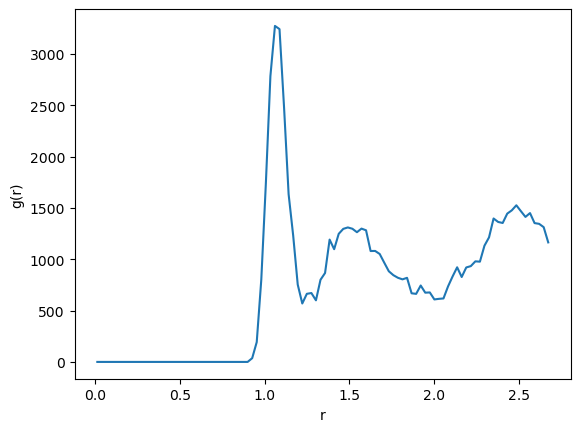

In [ ]:
fig, ax = plt.subplots()
bins = rdf[:,0]
g = rdf[:,1]
ax.plot(bins  , g)   
ax.set_xlabel('r')
ax.set_ylabel('g(r)')


Save positions as a trajectory and maybe visualise with ase 

In [ ]:
positions = np.load('positions.npy')
for idx, i in enumerate(positions):
    system = Atoms(['Ar'] * md_system.n_particles, positions = i * sigma_ar*1E10)
    system.set_cell([box_length_lj * sigma_ar*1E10, box_length_lj * sigma_ar*1E10, box_length_lj * sigma_ar*1E10])
    if idx == 0:
        ase.io.write('argon.xyz', system, append = False)
    else:
        ase.io.write('argon.xyz', system, append = True)